In [1]:
import sys
sys.path.append('../')

import stablemotifs
import biolqm
import ginsim
import StableMotifs as sm
import PyBoolNet
import boolsim
import timeit
import timeout_decorator
from timeout_decorator import TimeoutError
import pandas as pd
import glob
from colomoto_jupyter import tabulate
import numpy as np


## Generating Random Boolean Networks for the benchmarks

In [2]:

rbn_models_path='rbn_models_for_benchmark/'

#this part populates the folder given in rbn_models_path with random boolean networks
#WARNING! the folder already has models in it from previous runs, those will be ran too.
#for a completely fresh run, empty the folder, or specify the model files considered explicitly below in the model_set
K=2
p_bias=0.5
N_ensemble=1 # the number of networks of the same size
seed=1991
for N in range(10,30,5): #the range of sizes
    rbn_ensemble_rules=sm.RandomBooleanNetworks.Random_Boolean_Network_Ensemble_Kauffman(N,K,p_bias,N_ensemble,seed=seed,write_Boolean_network=False)
    for i in range(N_ensemble):
        with open(rbn_models_path+'rbn_N_%d_ens_%d.booleannet'%(N,i),'w') as f:
            f.write(rbn_ensemble_rules[i])
        

In [3]:

#run_ens_size is the number of times each method is repeatedly run IN THE SAME ITERATION. 
#this means that the timeout has to be increased proporionally to account for all runs
#In the final output the minimum (best) runtime is saved out of all in the ensemble 
run_ens_size=1 

#timeout limit in seconds for each method (all runs within the run_ens_size range). 
#If the timeout limit is reached the output will be -1
timeout_limit=3600 


#name of methods to be exluded from the run. This can be set manually if we know 
#that some methods are not relevant or take too much time
exclude_from_run=set(['bioLQM','PyBoolNet_Asp','PyBoolNet','Pint'])
#exclude_from_run=set(['bioLQM','PyBoolNet_Asp','PyBoolNet','Pint']) 
#uncomment the line abovr if you want only methods that look for complex attractors

#the excel file in which the dataframe summarizing the results will be saved.
output_file_name='timing_results_RBN.xlsx'

In [4]:
@timeout_decorator.timeout(timeout_limit)
def run_timed_test(method_runstring, setup, repeat):

    return timeit.repeat(method_runstring,setup=setup, repeat=repeat, number=1)

try:
    result_df=pd.read_excel(output_file_name)
    result_df=result_df.reset_index(drop=True)
except FileNotFoundError:
    result_df=pd.DataFrame()

result_df=pd.DataFrame()

#grabbing all the .booleannet models from the folder
model_set=glob.glob(rbn_models_path+'*.booleannet')
#model_set=['PSO.txt', 'phase_switch.txt','myeloid.txt']

for model_file_name in model_set:
    print('Running model %s'%model_file_name)
    
    base_setup_string='''import stablemotifs
import biolqm
import ginsim
import StableMotifs as sm
import PyBoolNet
import boolsim
import cabean
import pypint
from colomoto_jupyter import tabulate


model_file_name='%s'
with open(model_file_name) as f:
    rules=f.read().replace('#BOOLEAN RULES','').strip()
biolqm_model = biolqm.load(model_file_name, "booleannet")
pypint_model=biolqm.to_pint(biolqm_model)'''%model_file_name

    method_runstrings={'sm_jgtz': "a=stablemotifs.load(biolqm_model, quiet=True).attractors\ntabulate(a).to_excel('attr_output/attr_output_sm_jgtz_'+model_file_name.split('.')[0].split('/')[-1]+'.xlsx')",
                   
                   
 'stable_motifs_new': "ar = sm.AttractorRepertoire.from_primes(primes, max_simulate_size=max_simulate_size)\nex.attractor_dataframe(ar).to_excel('attr_output/attr_output_stable_motifs_new_'+model_file_name.split('.')[0].split('/')[-1]+'.xlsx')",
                   
                   
 'PyBoolNet': 'PyBoolNet.Attractors.compute_attractors_tarjan(PyBoolNet.StateTransitionGraphs.primes2stg(primes, "asynchronous"))\ntabulate(a).to_excel(\'attr_output/attr_output_PyBoolNet_\'+model_file_name.split(\'.\')[0].split(\'/\')[-1]+\'.xlsx\')',
                   
                   
 'boolsim': "a=boolsim.attractors(biolqm_model)\ntabulate(a).to_excel('attr_output/attr_output_boolsim_'+model_file_name.split('.')[0].split('/')[-1]+'.xlsx')",
                   
                   
 'bioLQM': "a=biolqm.fixpoints(biolqm_model)\ntabulate(a).to_excel('attr_output/attr_output_bioLQM_'+model_file_name.split('.')[0].split('/')[-1]+'.xlsx')",
                   
                   
 'PyBoolNet_Asp': "a=PyBoolNet.AspSolver.steady_states(primes)\ntabulate(a).to_excel('attr_output/attr_output_PyBoolNet_Asp_'+model_file_name.split('.')[0].split('/')[-1]+'.xlsx')",
                   
                   
 'CABEAN': "a=cabean.attractors(biolqm_model)\ntabulate(a).to_excel('attr_output/attr_output_CABEAN_'+model_file_name.split('.')[0].split('/')[-1]+'.xlsx')",
                   
                   
 'Pint': "a=pypint.fixpoints(pypint_model)\ntabulate(a).to_excel('attr_output/attr_output_Pint_'+model_file_name.split('.')[0].split('/')[-1]+'.xlsx')"}

    method_setups={'sm_jgtz':base_setup_string,

    'stable_motifs_new':base_setup_string+'''
max_simulate_size=20
rules_pbn = sm.Format.booleannet2bnet(rules)
primes = PyBoolNet.FileExchange.bnet2primes(rules_pbn)
import StableMotifs.Export as ex
''',

    'PyBoolNet':base_setup_string+'''
rules_pbn = sm.Format.booleannet2bnet(rules)
primes = PyBoolNet.FileExchange.bnet2primes(rules_pbn)
''',

    'boolsim':base_setup_string,

    'bioLQM':base_setup_string,

    'PyBoolNet_Asp':base_setup_string+'''
rules_pbn = sm.Format.booleannet2bnet(rules)
primes = PyBoolNet.FileExchange.bnet2primes(rules_pbn)
''',

    'CABEAN':base_setup_string,

    'Pint':base_setup_string}

    method_runtimes={i:[] for i in method_runstrings}
    
    
    for method_name in set(method_runstrings)-exclude_from_run:
        print('method:',method_name)
        try:
            method_runtimes[method_name]=run_timed_test(method_runstrings[method_name], setup=method_setups[method_name], repeat=run_ens_size)
        except Exception as e:
            print(str(e))
            method_runtimes[method_name].append(np.nan)
    runtime_minimums={k:min(method_runtimes[k]) for k in method_runtimes.keys()-exclude_from_run} 
    runtime_minimums['model']=model_file_name.split('.')[0].split('/')[-1]
    result_df=result_df.append([runtime_minimums],ignore_index=True)
    result_df=result_df.reset_index(drop=True)

    result_df.to_excel('timing_results.xlsx')

Running model rbn_models_for_benchmark/rbn_N_15_ens_0.booleannet
method: sm_jgtz


method: stable_motifs_new
method: boolsim
method: CABEAN
Running model rbn_models_for_benchmark/rbn_N_25_ens_0.booleannet
method: sm_jgtz
method: stable_motifs_new
method: boolsim
method: CABEAN
Running model rbn_models_for_benchmark/rbn_N_20_ens_0.booleannet
method: sm_jgtz
method: stable_motifs_new
method: boolsim
method: CABEAN
Running model rbn_models_for_benchmark/rbn_N_10_ens_0.booleannet
method: sm_jgtz
method: stable_motifs_new
method: boolsim
method: CABEAN


In [5]:
result_df.to_excel(output_file_name)

In [6]:
'''
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,8))
g=sns.barplot(list(runtime_minimums.keys()), list(runtime_minimums.values()),log=True)
for k, v in enumerate(runtime_minimums.values()):
    g.text(k,v, round(v,3), color='black', ha="center")
plt.xlabel('Method', fontsize=14)
plt.ylabel('Best time', fontsize=14)
plt.title('model:'+model_file_name.replace('.txt','')+'; run_ens:%d'%run_ens_size,fontsize=16)
plt.grid()
plt.savefig('benchmark_result_'+model_file_name.replace('.txt','.png'))
'''

'\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nplt.figure(figsize=(10,8))\ng=sns.barplot(list(runtime_minimums.keys()), list(runtime_minimums.values()),log=True)\nfor k, v in enumerate(runtime_minimums.values()):\n    g.text(k,v, round(v,3), color=\'black\', ha="center")\nplt.xlabel(\'Method\', fontsize=14)\nplt.ylabel(\'Best time\', fontsize=14)\nplt.title(\'model:\'+model_file_name.replace(\'.txt\',\'\')+\'; run_ens:%d\'%run_ens_size,fontsize=16)\nplt.grid()\nplt.savefig(\'benchmark_result_\'+model_file_name.replace(\'.txt\',\'.png\'))\n'

In [7]:
result_df

,stable_motifs_new,CABEAN,sm_jgtz,boolsim,model
0,0.100222,0.045845,2.586544,0.098615,rbn_N_15_ens_0
1,0.268761,0.133417,3.236817,0.114341,rbn_N_25_ens_0
2,0.646921,0.077695,7.409603,0.158740,rbn_N_20_ens_0
3,0.104098,0.057979,2.182873,0.096564,rbn_N_10_ens_0


In [8]:
result_df['N']=result_df.apply(lambda row: int(row['model'].split('N_')[-1].split('_')[0]),axis=1)
#result_df['ens']=result_df.apply(lambda row: int(row['model'].split('ens_')[-1].split('_')[0]),axis=1)

In [9]:
result_df

,stable_motifs_new,CABEAN,sm_jgtz,boolsim,model,N
0,0.100222,0.045845,2.586544,0.098615,rbn_N_15_ens_0,15
1,0.268761,0.133417,3.236817,0.114341,rbn_N_25_ens_0,25
2,0.646921,0.077695,7.409603,0.158740,rbn_N_20_ens_0,20
3,0.104098,0.057979,2.182873,0.096564,rbn_N_10_ens_0,10


In [10]:
mean_df=result_df.groupby('N').mean()
std_df=result_df.groupby('N').std()
std_df

,stable_motifs_new,CABEAN,sm_jgtz,boolsim
N,,,,
10,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,NaN
20,NaN,NaN,NaN,NaN
25,NaN,NaN,NaN,NaN


In [11]:
mean_df

,stable_motifs_new,CABEAN,sm_jgtz,boolsim
N,,,,
10,0.104098,0.057979,2.182873,0.096564
15,0.100222,0.045845,2.586544,0.098615
20,0.646921,0.077695,7.409603,0.158740
25,0.268761,0.133417,3.236817,0.114341


/home/david/anaconda2/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


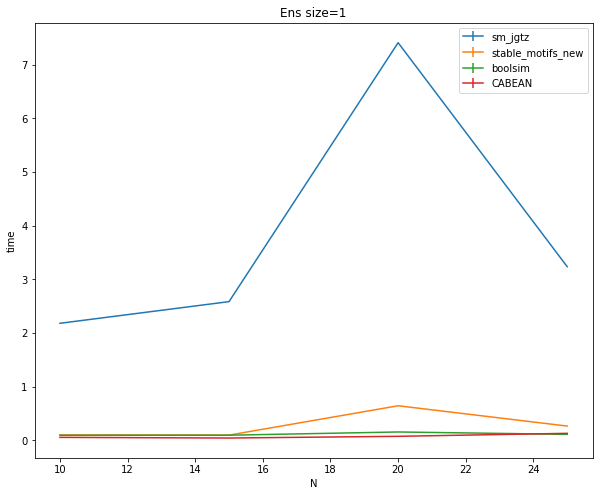

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))

for i in set(mean_df.columns):#-set(['sm_jgtz']):
    plt.errorbar(mean_df.index, mean_df[i],yerr=std_df[i],label=i)
plt.xlabel('N')
plt.ylabel('time')
plt.title('Ens size=%d'%N_ensemble)
plt.legend()    

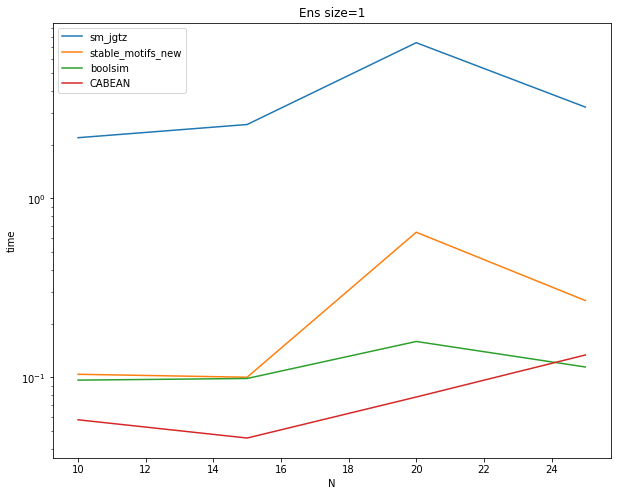

In [13]:
plt.figure(figsize=(10,8))

for i in set(mean_df.columns):#-set(['sm_jgtz']):
    plt.semilogy(mean_df.index, mean_df[i],label=i)
plt.legend()   
plt.xlabel('N')
plt.ylabel('time')
plt.title('Ens size=%d'%N_ensemble)
plt.legend()    